In [1]:
import torch, torchvision 

print(f"Pytorch vision: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

Pytorch vision: 2.4.1+cu124
Torchvision version: 0.19.1+cu124


### 1. Getting FahsionMINIST dataset

In [2]:
import torch
from torchvision import datasets, models, transforms

train_data_transform = transforms.Compose([
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   transform=train_data_transform,
                                   download=True,)

test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  transform=test_data_transform,
                                  download=True,)
print(f"Train dataset length: {len(train_data)}, Test dataset length: {len(test_data)}")
print(f"Train dataset data: {train_data.data}\nTrain dataset target: {train_data.targets}")
print(f"Test dataset data: {test_data.data}\nTest dataset target: {test_data.targets}")
class_label = dict(enumerate(train_data.classes))
print(f"Dataset label: {class_label}")

Train dataset length: 60000, Test dataset length: 10000
Train dataset data: tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

      

torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

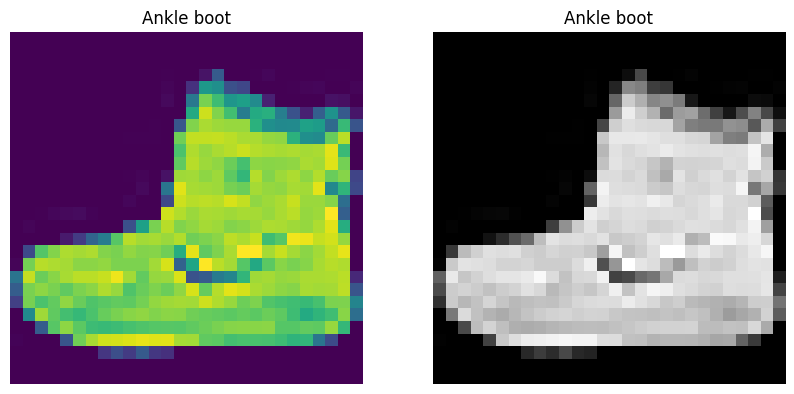

In [3]:
import matplotlib.pyplot as plt
image, label = train_data[0]
image_shape = image.shape
print(image_shape)
_, axs = plt.subplots(1, 2, figsize=(10, 5))
# imshow() require input with shape: (M, N), (M, N, 3) or (M, N, 4) with value 0-1 float or 0-255 int
axs[0].imshow(image.squeeze())
axs[0].set_title(train_data.classes[label])
axs[0].axis("Off")
axs[1].imshow(image.squeeze(), cmap="gray")
axs[1].set_title(train_data.classes[label])
axs[1].axis("Off")


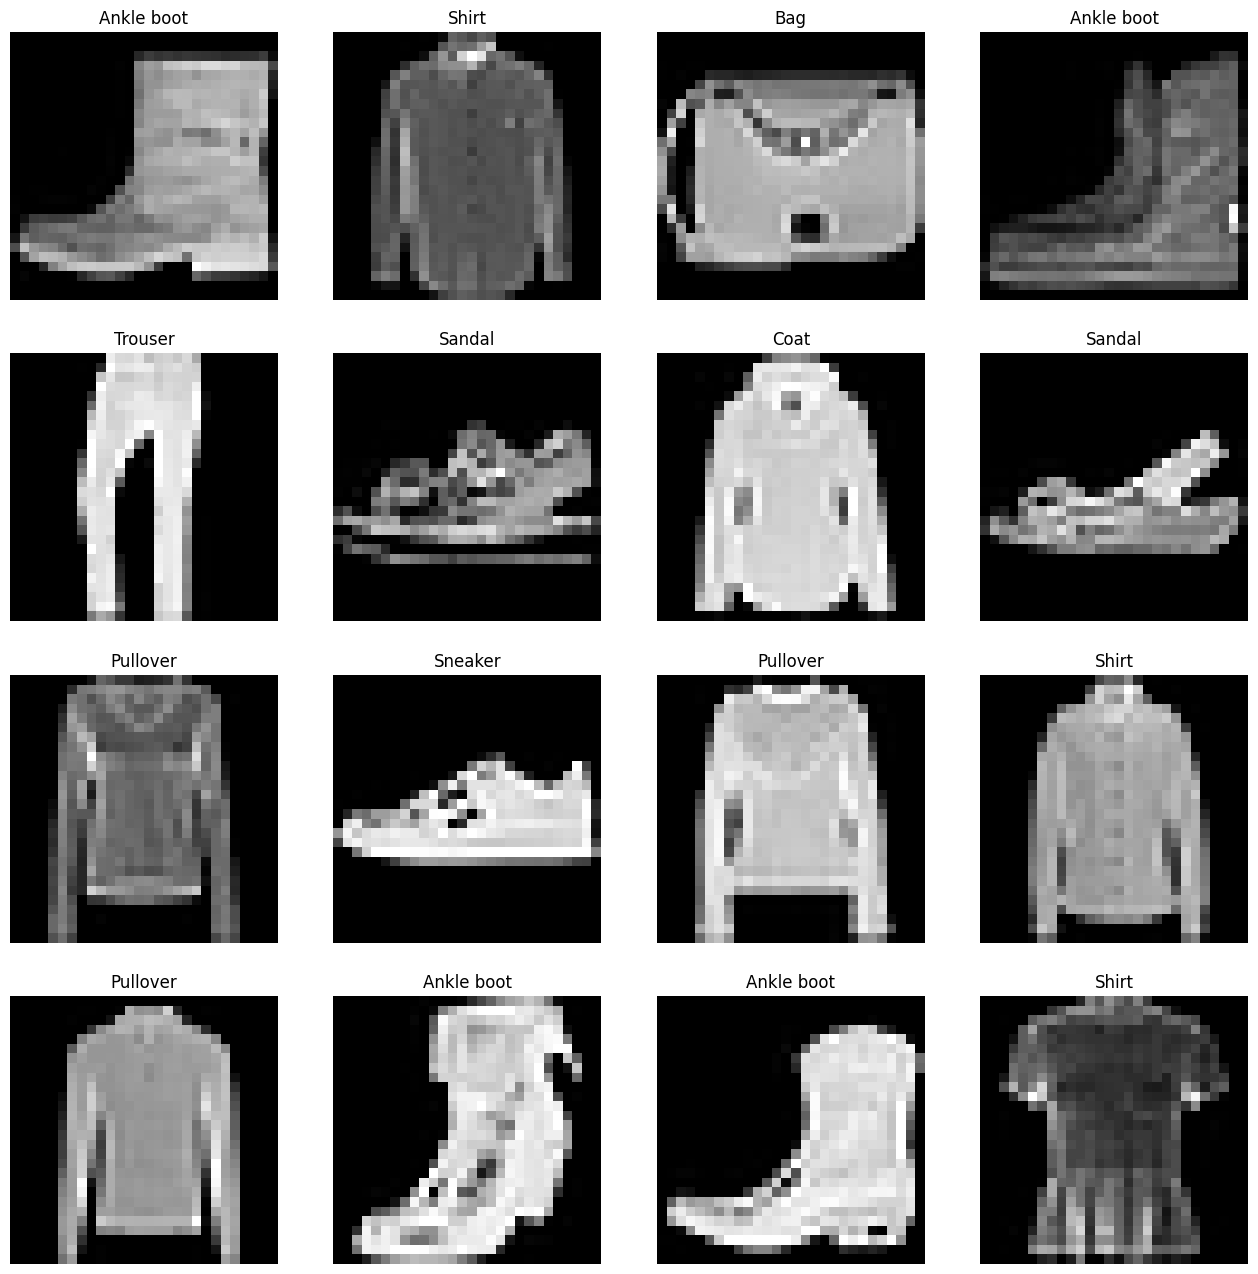

In [4]:
torch.manual_seed(42)
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        random_idx = torch.randint(low=0, high=len(train_data), size=(1,)).item()
        image, label = train_data[random_idx]
        axs[i, j].imshow(image.squeeze(), cmap="gray")
        axs[i, j].set_title(train_data.classes[label])
        axs[i, j].axis("Off")

### 2. Prepare DataLoader

In [5]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,)

print(f"Length of train dataloader: {len(train_dataloader)} batches with size {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches with size {BATCH_SIZE}")

Length of train dataloader: 1875 batches with size 32
Length of test dataloader: 313 batches with size 32


### 3.1 Model 0: Build a baseline model

In [6]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(), # flatten the input from dim 1 to dim -1
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [7]:
model_0 = FashionMNISTModelV0(input_dim=image.flatten().shape[0], output_dim=len(class_label), hidden_dim=100)

### 3.2 Setup loss, optimizer and evaluation metrics

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.1)

### 3.3 Setup training and test loops

In [9]:
from tqdm import tqdm

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model, dataloader, loss_fn, optimizer, device, accuracy_fn):

    train_loss, train_acc = 0, 0 
    model.to(device)
    model.train()
    batch = 0
    for (X, y) in dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=-1))
        batch = batch
    
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")


def test_step(model, dataloader, loss_fn, device, accuracy_fn):

    test_loss, test_acc = 0, 0 
    model.to(device)
    model.eval()
    batch = 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=y_pred.argmax(dim=-1))
            batch = batch
    
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}")


def eval_model(model, accuracy_fn, device, dataloader, loss_fn):

    loss, acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y).item()
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        loss /= len(dataloader)
        acc /= len(dataloader)
    
    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "model_acc": acc}



In [10]:
from helper_functions import accuracy_fn

EPOCH_NUM = 10

for epoch in tqdm(range(EPOCH_NUM)):
    print("-"*10 + f"Epoch{epoch}" + "-"*10)
    train_step(dataloader=train_dataloader,
               model=model_0,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(dataloader=test_dataloader,
              model=model_0,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

----------Epoch0----------
Train loss: 0.58470 | Train accuracy: 79.24333


 10%|█         | 1/10 [00:04<00:43,  4.80s/it]

Test loss: 0.45536 | Test accuracy: 83.52636
----------Epoch1----------
Train loss: 0.41087 | Train accuracy: 85.12167


 20%|██        | 2/10 [00:08<00:33,  4.22s/it]

Test loss: 0.41797 | Test accuracy: 85.03395
----------Epoch2----------
Train loss: 0.37225 | Train accuracy: 86.45333


 30%|███       | 3/10 [00:12<00:28,  4.04s/it]

Test loss: 0.39411 | Test accuracy: 85.74281
----------Epoch3----------
Train loss: 0.34647 | Train accuracy: 87.34000


 40%|████      | 4/10 [00:17<00:25,  4.25s/it]

Test loss: 0.37515 | Test accuracy: 86.54153
----------Epoch4----------
Train loss: 0.32967 | Train accuracy: 87.92000


 50%|█████     | 5/10 [00:21<00:21,  4.38s/it]

Test loss: 0.37562 | Test accuracy: 86.48163
----------Epoch5----------
Train loss: 0.31485 | Train accuracy: 88.44000


 60%|██████    | 6/10 [00:26<00:17,  4.47s/it]

Test loss: 0.36229 | Test accuracy: 86.82109
----------Epoch6----------
Train loss: 0.30162 | Train accuracy: 88.84333


 70%|███████   | 7/10 [00:30<00:13,  4.53s/it]

Test loss: 0.34424 | Test accuracy: 87.55990
----------Epoch7----------
Train loss: 0.29260 | Train accuracy: 89.09500


 80%|████████  | 8/10 [00:35<00:09,  4.57s/it]

Test loss: 0.36220 | Test accuracy: 87.02077
----------Epoch8----------
Train loss: 0.28376 | Train accuracy: 89.44500


 90%|█████████ | 9/10 [00:40<00:04,  4.59s/it]

Test loss: 0.36518 | Test accuracy: 87.28035
----------Epoch9----------
Train loss: 0.27669 | Train accuracy: 89.77833


100%|██████████| 10/10 [00:44<00:00,  4.48s/it]

Test loss: 0.33874 | Test accuracy: 87.52995


In [11]:
model_0_result = eval_model(model=model_0, dataloader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
model_0_result

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.0004730104638364749,
 'model_acc': 87.52995207667732}

### 4.1 Model 1: Building a Convolutional Neural Network 

In [12]:
class FashionMNISTModelV1(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_dim, 
                      out_channels=hidden_dim,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim,
                      out_channels=hidden_dim,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
            )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) # the default stride is the same as the input kernal size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=int(hidden_dim*(image_shape[1]/4)**2),
                      out_features=output_dim)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x
    
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_dim=1, hidden_dim=10, output_dim=len(class_label)).to(device)
model_1

FashionMNISTModelV1(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 4.2 Setup training and test loop

In [13]:
EPOCH_NUM = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr=0.1)

for epoch in tqdm(range(EPOCH_NUM)):
    print("-"*10 + f"Epoch{epoch}" + "-"*10)
    train_step(model=model_1,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               device=device,
               accuracy_fn=accuracy_fn)
    test_step(model=model_1,
              dataloader=test_dataloader,
              loss_fn=loss_fn,
              device=device,
              accuracy_fn=accuracy_fn)

  0%|          | 0/10 [00:00<?, ?it/s]

----------Epoch0----------
Train loss: 0.57745 | Train accuracy: 79.12833


 10%|█         | 1/10 [00:06<00:55,  6.12s/it]

Test loss: 0.39210 | Test accuracy: 85.53315
----------Epoch1----------
Train loss: 0.35626 | Train accuracy: 87.14333


 20%|██        | 2/10 [00:12<00:48,  6.04s/it]

Test loss: 0.37162 | Test accuracy: 86.12220
----------Epoch2----------
Train loss: 0.31679 | Train accuracy: 88.61500


 30%|███       | 3/10 [00:18<00:42,  6.01s/it]

Test loss: 0.32495 | Test accuracy: 88.19888
----------Epoch3----------
Train loss: 0.29357 | Train accuracy: 89.39333


 40%|████      | 4/10 [00:24<00:36,  6.01s/it]

Test loss: 0.32461 | Test accuracy: 87.94928
----------Epoch4----------
Train loss: 0.28073 | Train accuracy: 89.85000


 50%|█████     | 5/10 [00:30<00:30,  6.00s/it]

Test loss: 0.29713 | Test accuracy: 89.27716
----------Epoch5----------
Train loss: 0.27058 | Train accuracy: 90.11333


 60%|██████    | 6/10 [00:36<00:23,  6.00s/it]

Test loss: 0.30744 | Test accuracy: 88.99760
----------Epoch6----------
Train loss: 0.26268 | Train accuracy: 90.55000


 70%|███████   | 7/10 [00:42<00:17,  5.99s/it]

Test loss: 0.31836 | Test accuracy: 88.48842
----------Epoch7----------
Train loss: 0.25653 | Train accuracy: 90.68000


 80%|████████  | 8/10 [00:48<00:11,  5.99s/it]

Test loss: 0.28860 | Test accuracy: 89.75639
----------Epoch8----------
Train loss: 0.25044 | Train accuracy: 90.82667


 90%|█████████ | 9/10 [00:54<00:05,  5.99s/it]

Test loss: 0.28499 | Test accuracy: 89.70647
----------Epoch9----------
Train loss: 0.24472 | Train accuracy: 91.01333


100%|██████████| 10/10 [00:59<00:00,  6.00s/it]

Test loss: 0.27797 | Test accuracy: 89.81629


In [87]:
model_1_results = eval_model(model=model_1,
                           accuracy_fn=accuracy_fn,
                           device=device,
                           loss_fn=loss_fn,
                           dataloader=test_dataloader)

### 5. Make and evaluate random predictions with best model

In [57]:
import torch.nn.functional as F

def make_predictions(model, data, device):
    pred_result = []
    model.eval()
    model.to(device)
    with torch.inference_mode():
        for sample in data:
            sample = sample.unsqueeze(dim=0).to(device)
            pred_logit = model(sample)
            pre_prob = F.softmax(pred_logit.squeeze(), dim=-1)
            pred_result.append(pre_prob.to("cpu"))

# A list of tensor can not directly convert to Tensor using the torch.Tensor(list) method, it can be accomplished by stacking the tensor in the list
# But a list of numpy array can be directly convert to Tensor using the torch.Tenosr(list) method, alternatively modify to pred_result.append(pre_prob.to("cpu").numpy()))
    return torch.stack(pred_result, dim=0)

In [58]:
import random
random.seed(42)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs = make_predictions(model=model_1,
                              data=test_samples,
                              device=device)
pred_labels = pred_probs.softmax(dim=-1).argmax(dim=-1).tolist()
pred_labels, test_labels

([5, 1, 7, 4, 3, 6, 4, 7, 1], [5, 1, 7, 4, 3, 0, 4, 7, 1])

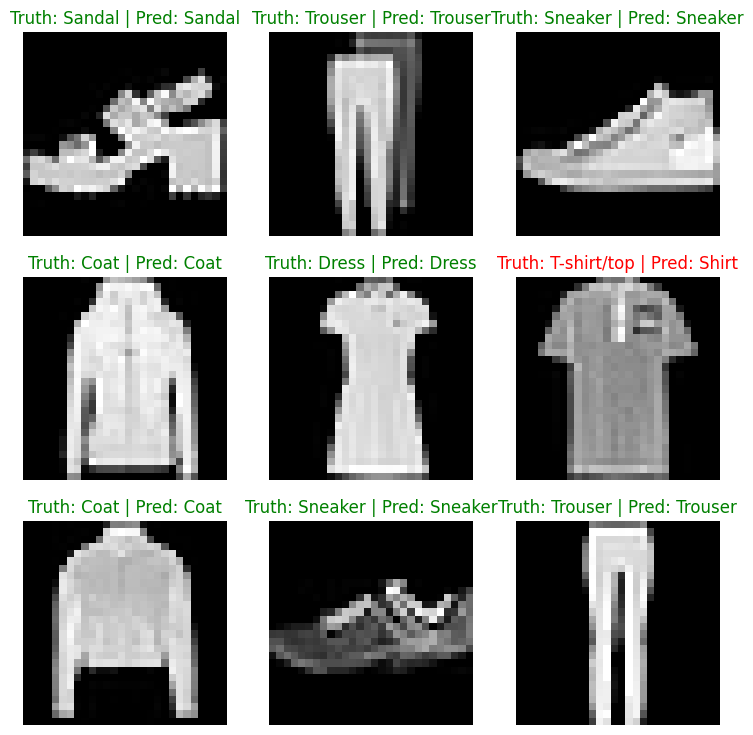

In [62]:
_, axs = plt.subplots(3, 3, figsize=(9,9))

for i, image in enumerate(test_samples):
    x = i // 3
    y = i % 3
    axs[x, y].imshow(image.squeeze(), cmap="gray")
    axs[x, y].axis("Off")
    if pred_labels[i] == test_labels[i]:
        axs[x, y].set_title(f"Truth: {class_label[test_labels[i]]} | Pred: {class_label[pred_labels[i]]}", c="green")
    else:
        axs[x, y].set_title(f"Truth: {class_label[test_labels[i]]} | Pred: {class_label[pred_labels[i]]}", c="red")


### 6. Making a confusion matrix for further prediction evaluation

In [76]:
from tqdm import tqdm

y_preds = []
model_1.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making prediction"):
        X, y = X.to(device), y.to(device)
        y_logits = model_1(X)
        y_pred = y_logits.softmax(dim=-1).argmax(dim=-1)
        y_preds.append(y_pred.cpu())
    y_pred_result = torch.cat(y_preds)
print(y_pred_result)

Making prediction: 100%|██████████| 313/313 [00:00<00:00, 656.23it/s]

tensor([9, 2, 1,  ..., 8, 1, 5])


In [72]:
import torchmetrics, mlxtend
print(torchmetrics.__version__, mlxtend.__version__)

1.5.0 0.23.1


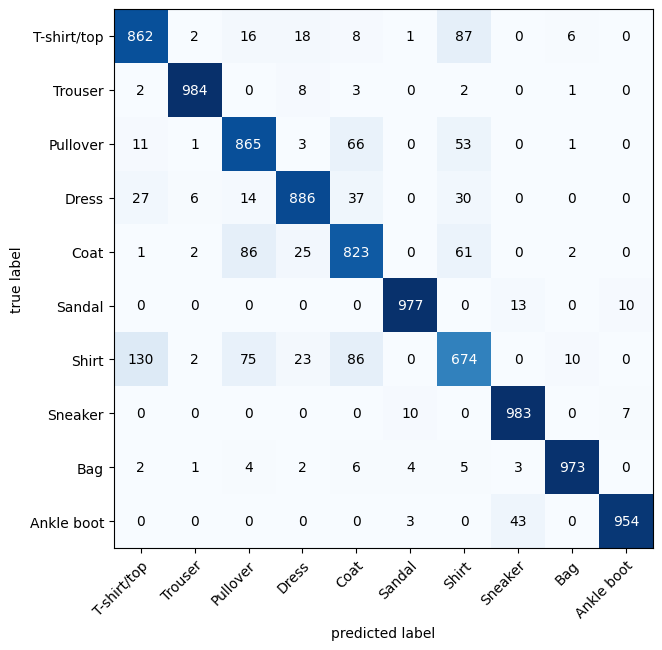

In [80]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_label))
confmat_tensor = confmat(preds=y_pred_result,
                         target=test_data.targets)

fig, axs = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=list(class_label.values()),
    figsize=(10, 7)
)

### 7. Save and load best performing model

In [81]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"

print(f"Saving model to: {MODEL_PATH / MODEL_NAME}")
torch.save(obj=model_1.state_dict(),f=MODEL_PATH / MODEL_NAME)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [84]:
loaded_model = FashionMNISTModelV1(input_dim=1,
                                   hidden_dim=10,
                                   output_dim=10)
loaded_model.load_state_dict(torch.load(f=MODEL_PATH / MODEL_NAME, weights_only=True))
loaded_model = loaded_model.to(device)

In [86]:
torch.manual_seed(42)

loaded_model_result = eval_model(
    model=loaded_model,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

loaded_model_result

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.000550723351990453,
 'model_acc': 89.81629392971246}

In [88]:
torch.isclose(torch.tensor(model_1_results["model_loss"]),
              torch.tensor(loaded_model_result["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001 # relative torlerance
              )

tensor(True)